Attrition Driver Analysis
---------------------------------
(Explainable Analysis)

Purpose:
- To identify behavioral, policy, and performance-related factors
  that are statistically associated with employee attrition.
- This analysis is diagnostic and explanatory in nature,
  focusing on understanding organizational patterns rather than
  predicting individual employee exits or providing early warnings.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer


In [ ]:
df = pd.read_csv("../data/employee_ml_dataset_v3.csv")


df["DaysSinceLastTraining"] = df["DaysSinceLastTraining"].replace(9999, np.nan)
df["YearsSinceLastRaise"]   = df["YearsSinceLastRaise"].replace(9999, np.nan)

df.loc[df["EngagementScore"] < 0, "EngagementScore"] = np.nan
df.loc[df["BurnoutRiskScore"] < 0, "BurnoutRiskScore"] = np.nan

y = df["AttritionFlag"]

print("Rows:", df.shape[0])
print("Attrition rate:", round(y.mean(), 3))

Rows: 15000
Attrition rate: 0.153


In [3]:
numeric_features = [
    "Salary",
    "TenureYears",
    "AbsenceDays_Last6M",
    "AbsenceFrequency_Last6M",
    "TrainingCount",
    "DaysSinceLastTraining",
    "YearsSinceLastRaise",
    "AvgOverallScore",
    "LastOverallScore",
    "AvgCommunication",
    "AvgTeamwork",
    "AvgProblemSolving",
    "EngagementScore",
    "BurnoutRiskScore"
]

In [4]:

# (Flags)
binary_features = [
    "EarlyTenureFlag",
    "HighPerformerFlag",
    "LongLeaveFlag",
    "HighAbsenceFlag",
    "PerformanceDropFlag",
    "NoTrainingFlag",
    "PayStagnationFlag",
    "CareerStagnationFlag"
]

In [5]:
ordinal_features = [
    "PerformanceRating"   # 1 → 5
]

In [6]:
drop_features = [
    "EmployeeID",   
    "Department",   
    "JobTitle",     
    "Gender",       
    "AttritionFlag" 
]

In [7]:
features = numeric_features + ordinal_features + binary_features
X = df[features]
y = df["AttritionFlag"]

In [8]:


preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            numeric_features
        ),
        (
            "ord",
            SimpleImputer(strategy="most_frequent"),
            ordinal_features
        ),
        (
            "bin",
            SimpleImputer(strategy="most_frequent"),
            binary_features
        )
    ]
)


In [9]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        solver="saga",
        penalty=None,
        max_iter=10000
    ))
])

pipe.fit(X, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ord', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Odds Ratios :

In [10]:
# Odds ratios represent the relative influence of each factor on attrition decisions.
# Values slightly above 1 indicate a small increase in the likelihood of attrition,
# while values below 1 indicate a protective effect.
# The small magnitude of most odds ratios confirms that attrition is not driven by
# a single dominant factor, but by the accumulation of multiple weak drivers acting together.

model = pipe.named_steps["model"]
coef = model.coef_[0]

odds_ratios = pd.DataFrame({
    "Feature": features,
    "Coefficient": coef,
    "OddsRatio": np.exp(coef)
}).sort_values("OddsRatio", ascending=False)

odds_ratios

,Feature,Coefficient,OddsRatio
17,LongLeaveFlag,0.689043,1.991808
15,EarlyTenureFlag,0.101024,1.106303
1,TenureYears,0.098032,1.102999
12,EngagementScore,0.089432,1.093553
2,AbsenceDays_Last6M,0.079282,1.082510
16,HighPerformerFlag,0.074554,1.077404
21,PayStagnationFlag,0.066845,1.069129
20,NoTrainingFlag,0.036766,1.037450
10,AvgTeamwork,0.024206,1.024501
11,AvgProblemSolving,0.017690,1.017847


In [11]:
feature_category_map = {
    # Behavioral
    "EngagementScore": "Behavioral",
    "BurnoutRiskScore": "Behavioral",
    "AbsenceDays_Last6M": "Behavioral",
    "AbsenceFrequency_Last6M": "Behavioral",
    "CareerStagnationFlag": "Behavioral",

    # Policy / Career
    "Salary": "Policy / Career",
    "YearsSinceLastRaise": "Policy / Career",
    "PayStagnationFlag": "Policy / Career",
    "TrainingCount": "Policy / Career",
    "DaysSinceLastTraining": "Policy / Career",
    "NoTrainingFlag": "Policy / Career",
    "TenureYears": "Policy / Career",

    # Performance
    "PerformanceRating": "Performance",
    "HighPerformerFlag": "Performance",
    "PerformanceDropFlag": "Performance",
    "AvgOverallScore": "Performance",
    "LastOverallScore": "Performance",
    "AvgCommunication": "Performance",
    "AvgTeamwork": "Performance",
    "AvgProblemSolving": "Performance"
}

In [12]:
feature_category_map.update({
    "LongLeaveFlag": "Behavioral",
    "EarlyTenureFlag": "Policy / Career"
})

In [13]:
odds_ratios["Category"] = odds_ratios["Feature"].map(feature_category_map)

odds_ratios

,Feature,Coefficient,OddsRatio,Category
17,LongLeaveFlag,0.689043,1.991808,Behavioral
15,EarlyTenureFlag,0.101024,1.106303,Policy / Career
1,TenureYears,0.098032,1.102999,Policy / Career
12,EngagementScore,0.089432,1.093553,Behavioral
2,AbsenceDays_Last6M,0.079282,1.082510,Behavioral
16,HighPerformerFlag,0.074554,1.077404,Performance
21,PayStagnationFlag,0.066845,1.069129,Policy / Career
20,NoTrainingFlag,0.036766,1.037450,Policy / Career
10,AvgTeamwork,0.024206,1.024501,Performance
11,AvgProblemSolving,0.017690,1.017847,Performance


In [14]:
odds_ratios.groupby("Category")["OddsRatio"].mean()


Category
Behavioral         1.178148
Performance        0.997722
Policy / Career    1.027514
Name: OddsRatio, dtype: float64

###  (Why attrition happens, explained feature‑by‑feature) : 



In [ ]:
import matplotlib.pyplot as plt

c:\Users\Hp\Desktop\Data Analysis bootcamp\python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Hp\Desktop\Data Analysis bootcamp\python\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


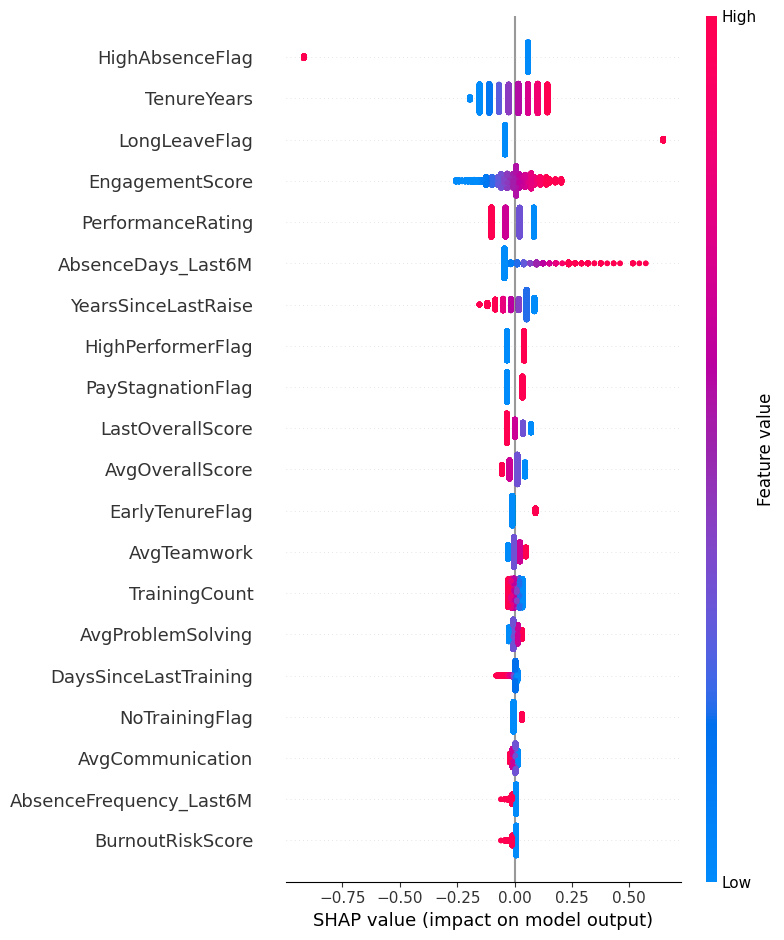

In [16]:
import shap

X_processed = pipe.named_steps["preprocessor"].transform(X)

explainer = shap.LinearExplainer(
    pipe.named_steps["model"],
    X_processed,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_processed)

shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=features
)

# SHAP values are computed on preprocessed (scaled) features.

🔼 SHAP Beeswarm Plot – Global Drivers of Employee Attrition
---------
This SHAP beeswarm plot explains how individual feature values influence employee attrition across the organization.

Each point represents an employee, where color indicates the feature value (🔴  = high, 🔵 = low),

 and the x‑axis shows the direction and magnitude of impact on attrition likelihood.

The results indicate that employee attrition is driven by the accumulation of multiple weak signals rather than a single dominant factor. 

Structural and policy‑related variables (such as absence patterns, tenure, and career progression) have a stronger overall influence than behavioral strain alone, 

supporting a multifactorial explanation of employee exits

In [17]:
X.isna().sum().sort_values(ascending=False).head(10)

DaysSinceLastTraining      2485
EngagementScore             952
TenureYears                   0
AbsenceDays_Last6M            0
AbsenceFrequency_Last6M       0
TrainingCount                 0
Salary                        0
YearsSinceLastRaise           0
AvgOverallScore               0
AvgCommunication              0
dtype: int64

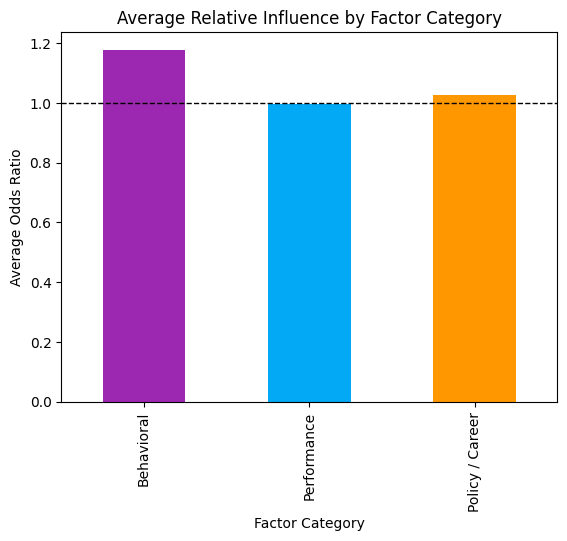

In [18]:
category_summary = odds_ratios.groupby("Category")["OddsRatio"].mean()

category_summary.plot(kind="bar", color=["#9C27B0", "#03A9F4", "#FF9800"])
plt.title("Average Relative Influence by Factor Category")
plt.ylabel("Average Odds Ratio")
plt.xlabel("Factor Category")
plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.show()


🔼This chart summarizes the average relative association of behavioral, policy/career, and performance-related factors with employee attrition.

Values above 1 indicate a positive association with attrition, while values close to 1 suggest a weak or neutral effect. 

The close proximity of all categories highlights that attrition is not driven by a single type of factor, but rather by the combined influence of multiple weak signals.


In [19]:
odds_ratios.head(15)

,Feature,Coefficient,OddsRatio,Category
17,LongLeaveFlag,0.689043,1.991808,Behavioral
15,EarlyTenureFlag,0.101024,1.106303,Policy / Career
1,TenureYears,0.098032,1.102999,Policy / Career
12,EngagementScore,0.089432,1.093553,Behavioral
2,AbsenceDays_Last6M,0.079282,1.082510,Behavioral
16,HighPerformerFlag,0.074554,1.077404,Performance
21,PayStagnationFlag,0.066845,1.069129,Policy / Career
20,NoTrainingFlag,0.036766,1.037450,Policy / Career
10,AvgTeamwork,0.024206,1.024501,Performance
11,AvgProblemSolving,0.017690,1.017847,Performance


Conclusion
---------------------------------

This analysis demonstrates that employee attrition is not driven by a single factor, but rather by the interaction of multiple weak signals.

The findings show that structural and career-related factors—such as absence patterns, tenure stage,

and development or progression signals—have a stronger overall association with attrition than behavioral strain alone. 
 
While engagement and burnout contribute to attrition risk, they do not independently explain why employees leave.

Overall, attrition emerges as a multifactorial organizational outcome, where cumulative pressures and contextual conditions matter more than any isolated variable. 

The value of this analysis lies in explaining these patterns at an organizational level to support informed HR and policy decisions.

